<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04b_Creating_Turbulence_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 04 (b): Creating a Turbulence Model

### In this section you will:


*   Create a turbulence function that estimates turbulence with a rolling window.
*   Transform a turbulence signal into set of dynamic weights. Track performance of the model.
*   Optimize the lookback and smoothing window.


## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [0]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
import bisect
from scipy import stats

### Read in data from previously stored returns.pkl file



In [3]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Create a function that calculates turbulence for the whole window supplied using the last row as the observed return

Note that for faster computation we can replace ``` np.linalg.pinv(covmat)@(r - mu) ``` with ``` np.linalg.lstsq(covmat, r - mu)[0] ```

Also note that a more proper calculation of turbulence would only use rows 1:n-1 to calculate mean and covariance. But everybody seems to include n, so we aren't going to get upset here because it is simpler.

In [0]:
def simple_turbulence(rets):
  meanret = rets.mean()
  covrets = rets.cov()
  turbvalue = (rets[-1:]-meanret)@np.linalg.lstsq(covrets,(rets[-1:]-meanret).T, rcond=None)[0]
  turbvalue.columns = ['daily']
  return turbvalue

In [5]:
turb_singleday = simple_turbulence(returns)
turb_singleday

,daily
2017-12-26,1.944164


### Create a function that calculates rolling turbulence given a lookback window and a smoothing window

To do this, we are going to create a function ```roll``` that generates a rolling window of returns for a specified window length, and a function that applies the turbulence calculation to that window.

In [0]:
def roll(df, w):
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w], df.columns)
  
def rolling_turbulence(rets, lookback=260, smoothing=20):
    roll_turb = pd.concat([simple_turbulence(retwindow) for retwindow in roll(rets, lookback)], axis=0)
    roll_turb_smooth = pd.DataFrame(roll_turb.rolling(smoothing).mean()).rename(columns={'daily':'smoothed'})
    rets = rets.join(roll_turb)
    rets = rets.join(roll_turb_smooth)
    return rets[['daily','smoothed']]

In [7]:
roll_turb = rolling_turbulence(returns, lookback=260, smoothing=20)
roll_turb.tail(20)

,daily,smoothed
2017-11-29,11.708329,8.198902
2017-11-30,19.434739,8.275519
2017-12-01,16.035338,8.625853
2017-12-04,3.472929,8.539207
2017-12-05,4.495685,8.672033
2017-12-06,15.095148,9.194906
2017-12-07,6.858294,9.277124
2017-12-08,4.493710,9.385128
2017-12-11,15.851664,9.848611
2017-12-12,14.919482,9.333394


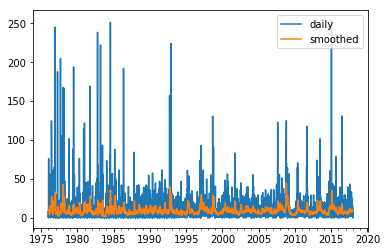

In [8]:
roll_turb.plot()

### Convert rolling turbulence into a weight (And do so in a function)

Turbulence as a raw statistic ranges between 0 and infinity. It cannot be directly used for investment strategies without some kind of transformation into model weights.

Our most obvious optiions are to create a binary cutoff or linear ranking. We are going to use linear ranking, though there are reasons why you might want to use a binary cutoff (simple on/off model).

The linear ranking, when used in-sample, should map results to a uniform distribution.

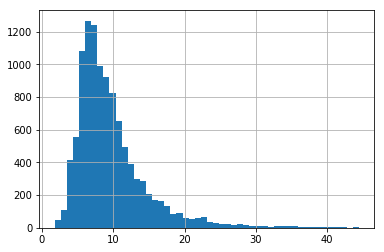

In [9]:
roll_turb['smoothed'].hist(bins=50)

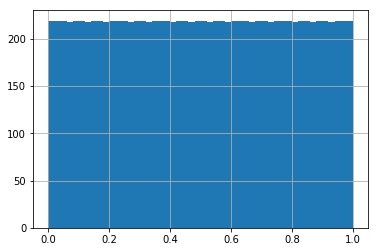

In [10]:
historical_turb_rank = roll_turb['smoothed'].dropna().rank()/roll_turb['smoothed'].count()
historical_turb_rank.hist(bins=50)


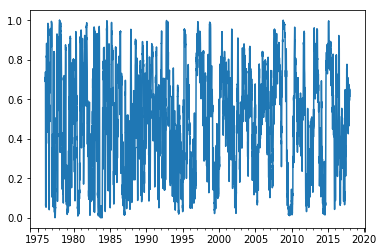

In [11]:
insample_start_date = '1975-01-02'
insample_end_date = '2000-01-01'
insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
insample_turb.sort()
num_insample = np.size(insample_turb)
roll_turb['ranked'] = np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample)
roll_turb['ranked'].plot()

In [0]:
def turbulence_weights(roll_turb, insample_start_date, insample_end_date):
  insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
  insample_turb.sort()
  num_insample = np.size(insample_turb)
  turb_weights = pd.DataFrame(np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample), index=roll_turb.index)
  turb_weights.columns=['weights']
  return turb_weights

In [25]:
turb_weights = turbulence_weights(roll_turb, '1975-01-02', '2000-01-01')
turb_weights.tail(20)

,weights
2017-11-29,0.504805
2017-11-30,0.510730
2017-12-01,0.543722
2017-12-04,0.536355
2017-12-05,0.547406
2017-12-06,0.593530
2017-12-07,0.600897
2017-12-08,0.608424
2017-12-11,0.647822
2017-12-12,0.604901


### Calculate the performance of the turbulence model

Leveraging the framework we developed in Part 3, we calculate the excess performance of the model.


In [0]:
def model_perf(model_wts, dxyfsq, framework_params):
  # Note, since chapter 3, modified the code a little to handle the possibility that column headings are not constant
  
  model_vol = pd.DataFrame()
  model_vol['total'] = model_wts[model_wts.columns[0]]*dxyfsq[dxyfsq.columns[0]] 
  model_vol['avg'] = (np.mean(model_wts.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()[model_wts.columns[0]])*dxyfsq)

  is_model_vol = model_vol.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()
  out_model_vol = model_vol.loc[framework_params['outofsample_start_date']:framework_params['outofsample_end_date']].dropna()
  
  is_vol_rmse = np.sqrt(np.mean(is_model_vol))
  out_vol_rmse = np.sqrt(np.mean(out_model_vol))
  
  model_perf_stats = {'insample rmse': is_vol_rmse['total'], 'insample excess rmse': is_vol_rmse['total'] - is_vol_rmse['avg'],
                        'out-of-sample rmse': out_vol_rmse['total'], 'out-of-sample excess rmse': out_vol_rmse['total'] - out_vol_rmse['avg']}

  if framework_params.get('verbose',False):
    model_perf_stats['insample model volatility'] = is_model_vol
    model_perf_stats['out-of-sample model volatility'] = out_model_vol
  return model_perf_stats

In [127]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = pd.DataFrame(returns.dot(dxy_weight))
dxy_forward = dxy.shift(-1)
dxy_forward_sq = dxy_forward**2

model_perf(turb_weights, dxy_forward_sq, framework_params)

{'insample excess rmse': 0.0002099394644574184,
 'insample rmse': 0.0036668027909790577,
 'out-of-sample excess rmse': 0.0002046628705417203,
 'out-of-sample rmse': 0.0033668848494255734}

### Test significance of excess volatility

A simple test of the ability of a turbulence model to outperform a random model is to calculate the significance of the average excess volatility.

We can calculate this by looking at the difference between the 

In [132]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': True}

model_perf_stats = model_perf(turb_weights, dxy_forward_sq, framework_params)

stats.ttest_rel(model_perf_stats['insample model volatility']['total'], model_perf_stats['insample model volatility']['avg'])

Ttest_relResult(statistic=5.683095936183465, pvalue=1.3825260997270177e-08)

In [133]:
stats.ttest_rel(model_perf_stats['out-of-sample model volatility']['total'], model_perf_stats['out-of-sample model volatility']['avg'])

Ttest_relResult(statistic=6.578732513461931, pvalue=5.263650715914841e-11)